In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394129 sha256=d3615a2d677824584aecc351a40d3f168f92cff9a97566c4b87bd3d40c1aeb63
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [4]:
import os
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, auc, plot_roc_curve
from sklearn.externals import joblib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
sys.path.append("/content/drive/My Drive/2020 Spring/RDS/rds-project/")
from ads_utils import *
import pickle
import matplotlib.pyplot as plt
from numpy import interp


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Config Settings

In [0]:
DATA_DIRECTORY = "/content/drive/My Drive/2020 Spring/RDS/rds-project/data"#"../input/"
INPUT_DATA = os.path.join(DATA_DIRECTORY, "engineered_df.csv")
SUBMISSION_SUFIX = "_model2_04"
OUTPUT_DIR = "/content/drive/My Drive/2020 Spring/RDS/rds-project/output"
AUC_file = os.path.join(OUTPUT_DIR,"AUC_list.pickle")

RANDOM_SEED = 737851
RECALC = False

seed_folders = ["30", "45", "67", "210", "737", "original"]

# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS
GENERATE_SUBMISSION_FILES = True
STRATIFIED_KFOLD = False
#RANDOM_SEED = 737851
NUM_FOLDS = 10
EARLY_STOPPING = 100

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

# Model Stability

## Pulling and saving results for analysis

In [0]:
def load_model(seed_folder, data, categorical_feature = None, add_suffix=""):
    df = data[data['TARGET'].notnull()]
    test = data[data['TARGET'].isnull()]
    print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))
    del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
    predictors = list(filter(lambda v: v not in del_features, df.columns))
    
    if seed_folder=="original":
        RANDOM_SEED = 737851
    else:
        RANDOM_SEED = int(seed_folder)
    print(f"Random seed: {RANDOM_SEED}")
    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        
    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    sub_preds = np.zeros(test.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()
    AUC_list = []

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['TARGET'])):
        train_x, train_y = df[predictors].iloc[train_idx], df['TARGET'].iloc[train_idx]
        valid_x, valid_y = df[predictors].iloc[valid_idx], df['TARGET'].iloc[valid_idx]

        print(f'Loading from {"n_fold_"+str(n_fold)+".pkl"}')
        clf = joblib.load(os.path.join(OUTPUT_DIR, seed_folder, "n_fold_"+str(n_fold)+".pkl"))
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[predictors], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['auc']

        AUC_list.append(roc_auc_score(valid_y, oof_preds[valid_idx]))
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
        
    AUC_list.append(roc_auc_score(df['TARGET'], oof_preds))
    print('Full AUC score %.6f' % roc_auc_score(df['TARGET'], oof_preds))
    test['TARGET'] = sub_preds.copy()
    
    with open(os.path.join(OUTPUT_DIR, seed_folder ,"AUC_list.pickle"), "wb") as f:
        pickle.dump(AUC_list, f)

    # Get the average feature importance between folds
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    
    return mean_importance, AUC_list

In [0]:
AUC_dict = {}

with timer("Loading engineered features"):
    df = pd.read_csv(os.path.join(DATA_DIRECTORY, "engineered_df.csv"))
    print(f"Engineered df shape: {df.shape}")
lgbm_categorical_feat = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE']

for d in os.listdir(OUTPUT_DIR):
    seed_folder = os.path.join(OUTPUT_DIR,d)
    if os.path.isdir(seed_folder):
        with timer(f"Loading model {d}"):
            _, AUC_list = load_model(d, df, lgbm_categorical_feat)
            AUC_dict[d] = AUC_list

with open(AUC_file, "wb") as f:
        pickle.dump(AUC_dict, f)

## Load Data and Results



In [12]:
with timer("Loading engineered features"):
    data = pd.read_csv(os.path.join(DATA_DIRECTORY, "engineered_df.csv"))
    print(f"Engineered df shape: {data.shape}")
with open(AUC_file, "rb") as f:
    loaded_AUCS = pickle.load(f)
oof = pd.read_csv(os.path.join(OUTPUT_DIR,"original","oof_model2_04.csv"), index_col=0)
test_preds = pd.read_csv(os.path.join(OUTPUT_DIR,"original", "submission_model2_04.csv"))
df = data[data['TARGET'].notnull()]
del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
predictors = list(filter(lambda v: v not in del_features, df.columns))
folds = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)

Engineered df shape: (356250, 660)
Loading engineered features - done in 33s


## Plot Cross-Validation ROC results

Loading from n_fold_0.pkl
Loading from n_fold_1.pkl
Loading from n_fold_2.pkl
Loading from n_fold_3.pkl
Loading from n_fold_4.pkl
Loading from n_fold_5.pkl
Loading from n_fold_6.pkl
Loading from n_fold_7.pkl
Loading from n_fold_8.pkl
Loading from n_fold_9.pkl
AUC by fold: 
[0.7957877675607198, 0.7967547334202368, 0.8021055527782173, 0.8016386631659205, 0.7954139812890179, 0.8049118864592213, 0.800885362683174, 0.7981216509510877, 0.8014959889517811, 0.8017202860351871]


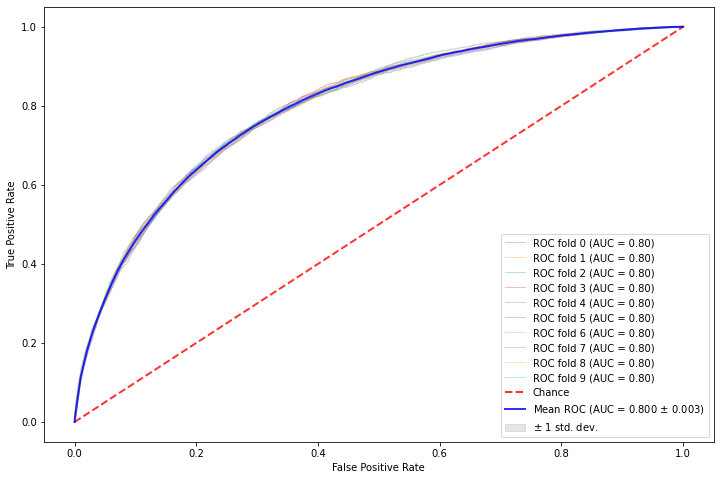

In [8]:
# df = data[data['TARGET'].notnull()]

# del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
# predictors = list(filter(lambda v: v not in del_features, df.columns))

# folds = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(12,8))
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['TARGET'])):
    train_x, train_y = df[predictors].iloc[train_idx], df['TARGET'].iloc[train_idx]
    valid_x, valid_y = df[predictors].iloc[valid_idx], df['TARGET'].iloc[valid_idx]

    print(f'Loading from {"n_fold_"+str(n_fold)+".pkl"}')
    clf = joblib.load(os.path.join(OUTPUT_DIR, "original", "n_fold_"+str(n_fold)+".pkl"))
    viz = plot_roc_curve(clf, valid_x, valid_y,
                         name='ROC fold {}'.format(n_fold),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="")
ax.legend(loc="lower right")

plt.savefig(os.path.join(OUTPUT_DIR,"ROC.png"))
print(f"AUC by fold: \n{loaded_AUCS['original'][:10]}")
plt.show()

We see here from the k-fold cross validation (k=10) that the model is very stable, obtaining curves that pretty much overlap each other. When rounded to two decimal points, the AUC for each fold is 0.8, and the model doesn't vary much from fold to fold. 

#Model Explainablility

## Overall Results

In [0]:
#Grab specific data split for model with best AUC

train_idx, valid_idx = list(folds.split(df[predictors], df['TARGET']))[2]
train_x, train_y = df[predictors].iloc[train_idx], df['TARGET'].iloc[train_idx]
valid_x, valid_y = df[predictors].iloc[valid_idx], df['TARGET'].iloc[valid_idx]
clf = joblib.load(os.path.join(OUTPUT_DIR, "original", "n_fold_"+str(2)+".pkl"))
if RECALC:
    result = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_, pred_contrib=True)
    with open(os.path.join(OUTPUT_DIR,"original","pred_contrib.pickle"), "wb") as f:
        pickle.dump(result,f)


In [0]:
proba_y = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)
pred_y = clf.predict(valid_x, num_iteration=clf.best_iteration_)

In [9]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     28359
         1.0       0.56      0.06      0.10      2392

    accuracy                           0.92     30751
   macro avg       0.75      0.53      0.53     30751
weighted avg       0.90      0.92      0.89     30751



This dataset is very imbalanced, as would be expected of default risk data. We see here that when the threshold for a person being classified as high risk (class 1) is set naively at 0.5, the result is that the majority class (0) has very high precision and recall, and the minority class (1) has very low precision and recall. Whoever intends to use this model will need to decide on the optimal precision and recall to determine a better threshold for classifying.

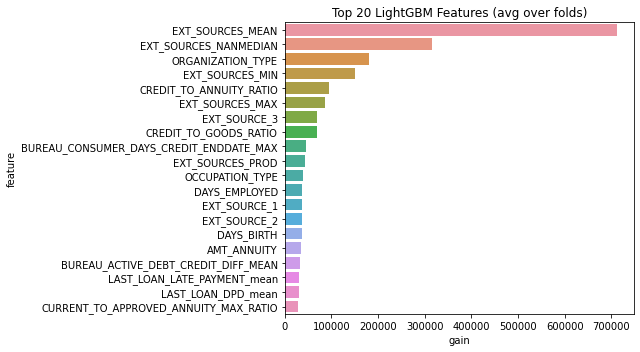

In [10]:
import seaborn as sns

feature_importances = pd.read_csv(os.path.join(OUTPUT_DIR,"original","feature_importance_model2_04.csv"))

plt.figure(figsize=(9, 5))
sns.barplot(x="gain", y="feature", data=feature_importances.sort_values(by="gain", ascending=False).head(20))
plt.title('Top 20 LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,'lgbm_importances.png'))
plt.show()


We see here that the that many of the features are some form of `EXT_SOURCES`, where some are original features from the application dataset (`EXT_SOURCE_1`,`EXT_SOURCE_2`,`EXT_SOURCE_3`), and others are new features that are some aggregate form of the previously mentioned features, added during feature engineering. The Kaggle dataset does not specify what these values are, only that they are "normalized scores from external datasets".

## Shap for explainability

In [15]:
import shap
import matplotlib.pyplot as plt
#shap.initjs()
with timer("setting up shap explainer"):
    explainer = shap.TreeExplainer(clf)
with timer("shap values"):
    if RECALC:
        #SHAP takes too long to compute, so we compute this once and save to file to load for later runs
        shap_values = explainer.shap_values(valid_x)
        with open(os.path.join(OUTPUT_DIR, "shap_values.pickle"), "wb") as f:
            pickle.dump(shap_values, f)
    else:
        with open(os.path.join(OUTPUT_DIR, "shap_values.pickle"), "rb") as f:
            shap_values = pickle.load(f)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


setting up shap explainer - done in 4s
shap values - done in 9s


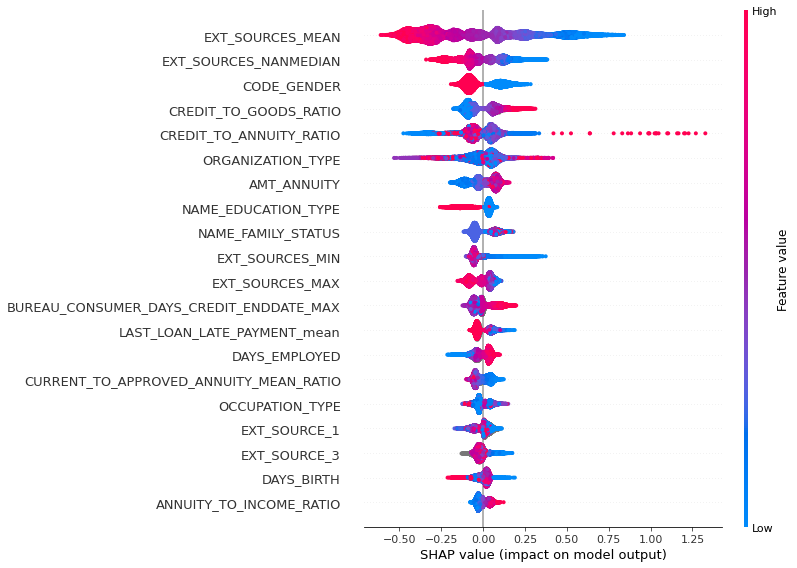

In [20]:
shap.summary_plot(shap_values[1], valid_x, show=False)
fig1 = plt.gcf()
fig1.savefig(os.path.join(OUTPUT_DIR,"shap_summary_1.png"))

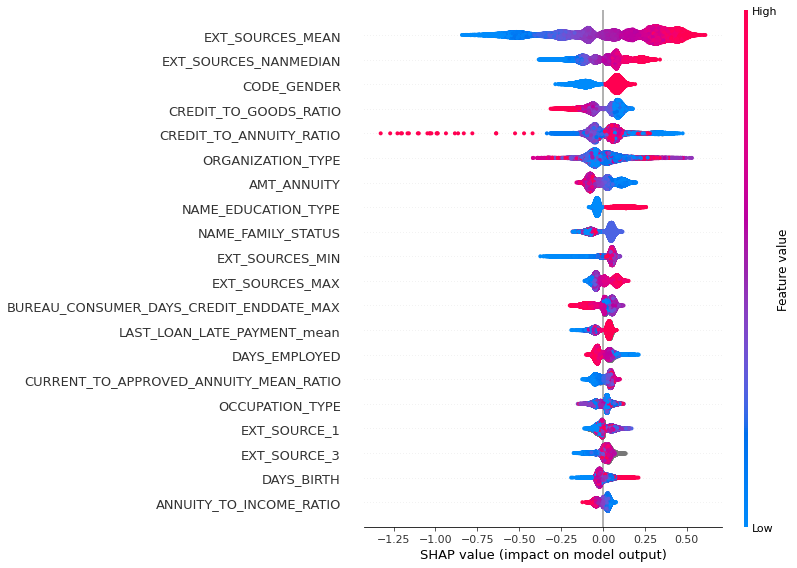

In [26]:
shap.summary_plot(shap_values[0], valid_x, show=False)
fig0 = plt.gcf()
fig0.savefig(os.path.join(OUTPUT_DIR,"shap_summary_0.png"))


invalid value encountered in subtract


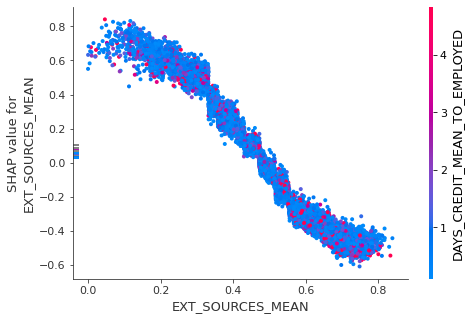

In [25]:
shap.dependence_plot("EXT_SOURCES_MEAN",shap_values[1],valid_x, show=False)
fig = plt.gcf()
fig.savefig(os.path.join(OUTPUT_DIR,"shap_ext_sources_mean.png"))

invalid value encountered in subtract


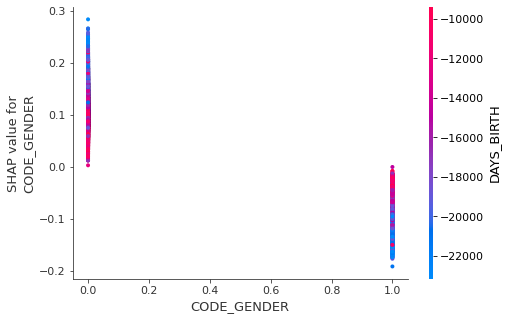

In [27]:
shap.dependence_plot("CODE_GENDER",shap_values[1],valid_x, show=False)
fig_gender = plt.gcf()
fig_gender.savefig(os.path.join(OUTPUT_DIR,"shap_gender.png"))

invalid value encountered in subtract


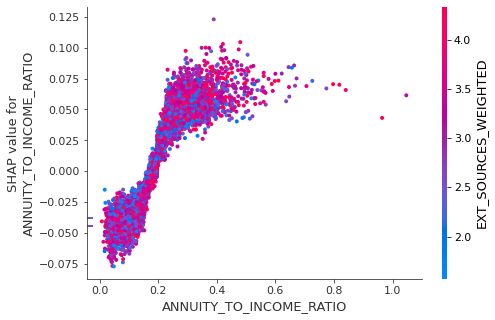

In [28]:
shap.dependence_plot("ANNUITY_TO_INCOME_RATIO",shap_values[1],valid_x, show=False)
fig_amt_annuity = plt.gcf()
fig_amt_annuity.savefig(os.path.join(OUTPUT_DIR,"shap_annuity_income.png"))

invalid value encountered in subtract


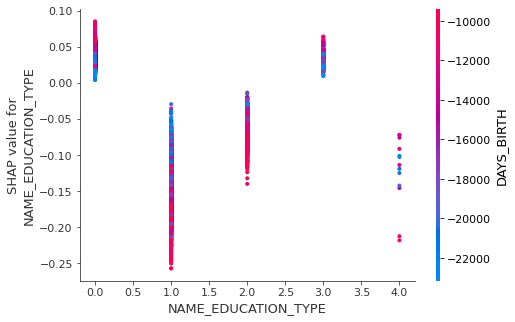

In [29]:
shap.dependence_plot("NAME_EDUCATION_TYPE",shap_values[1],valid_x, show=False)
fig = plt.gcf()
fig.savefig(os.path.join(OUTPUT_DIR,"shap_name_edu.png"))

invalid value encountered in subtract


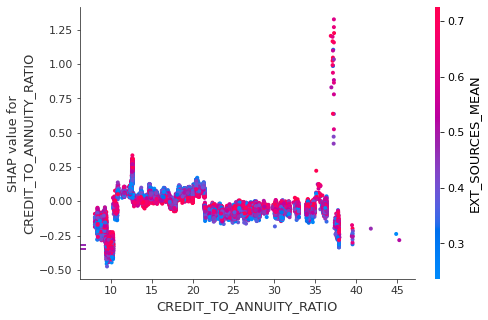

In [27]:
shap.dependence_plot("CREDIT_TO_ANNUITY_RATIO",shap_values[1],valid_x, show=False)
fig = plt.gcf()
fig.savefig(os.path.join(OUTPUT_DIR,"shap_credit_annuity.png"))

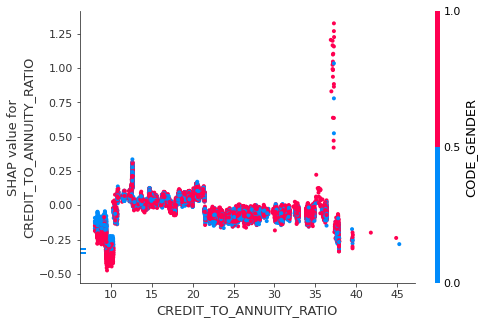

In [30]:
shap.dependence_plot("CREDIT_TO_ANNUITY_RATIO",shap_values[1],valid_x, interaction_index="CODE_GENDER", show=False)
fig = plt.gcf()
fig.savefig(os.path.join(OUTPUT_DIR,"shap_credit_annuity_gender.png"))

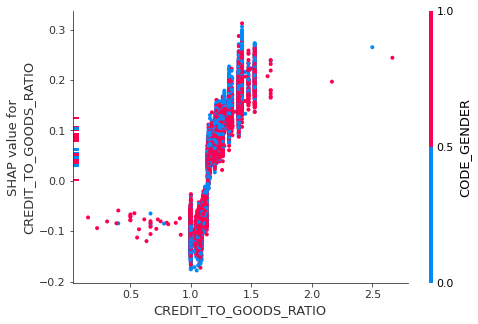

In [31]:
shap.dependence_plot("CREDIT_TO_GOODS_RATIO",shap_values[1],valid_x, interaction_index="CODE_GENDER", show=False)
fig = plt.gcf()
fig.savefig(os.path.join(OUTPUT_DIR,"shap_credit_goods_gender.png"))

invalid value encountered in subtract


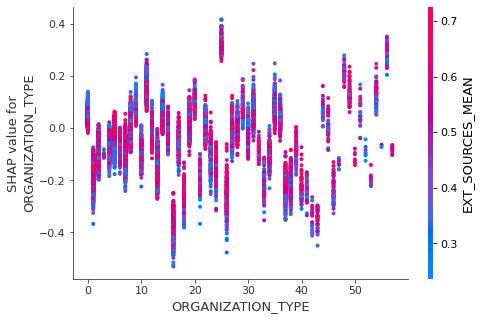

In [32]:
shap.dependence_plot("ORGANIZATION_TYPE",shap_values[1],valid_x, show=False)
fig = plt.gcf()
fig.savefig(os.path.join(OUTPUT_DIR,"org_type.png"))

invalid value encountered in subtract


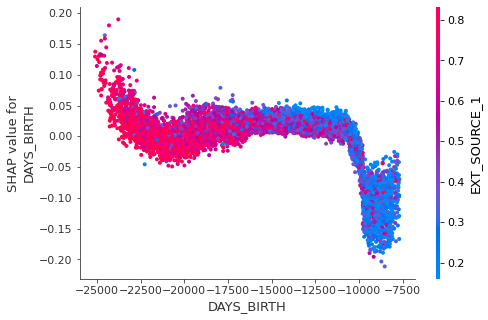

In [33]:
shap.dependence_plot("DAYS_BIRTH",shap_values[1],valid_x, show=False)
fig = plt.gcf()
fig.savefig(os.path.join(OUTPUT_DIR,"shap_days_birth.png"))

invalid value encountered in subtract


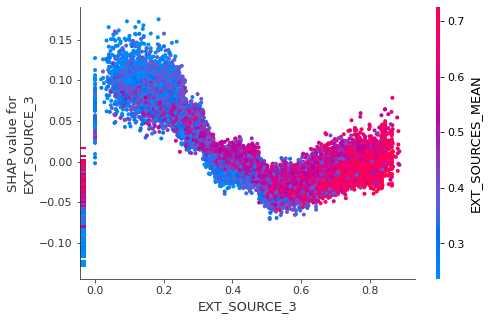

In [12]:
shap.dependence_plot("EXT_SOURCE_3",shap_values[1],valid_x, show=False)
fig = plt.gcf()
fig.savefig(os.path.join(OUTPUT_DIR,"shap_ext_source_3.png"))

invalid value encountered in subtract


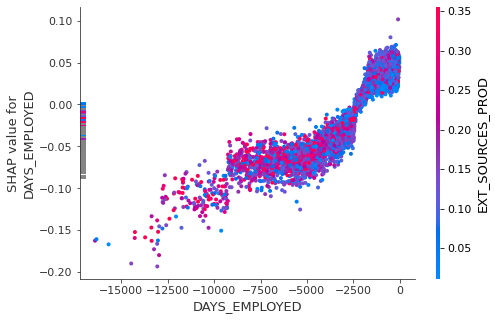

In [23]:
shap.dependence_plot("DAYS_EMPLOYED",shap_values[1],valid_x, interaction_index = "auto", show=False)
fig = plt.gcf()
fig.savefig(os.path.join(OUTPUT_DIR,"shap_days_employed.png"))